In [1]:
import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, Dataset, Subset

from smallnet import LinearNet, Net, split_dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        output = clf(images)
        loss = criterion(output, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def epoch_test(loader, clf, criterion):
    clf.eval()
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        output = clf(images)
        loss = criterion(output, labels)
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, PATH='/content/drive/MyDrive/ML/model.pth'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

        torch.save({
            'epoch': epoch,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, PATH)

## CIFAR-10

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_transform = transforms.Compose([
    #transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=30),
    transforms.RandomCrop(32, padding=2),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### Fine-tune Pretrained Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EPOCHS = 40

clf = torchvision.models.resnet18(num_classes=10).to(device)
opt = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(train_loader, test_loader, clf, criterion, opt, n_epochs=EPOCHS)

In [ ]:
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, PATH)

## MNIST

In [12]:
BATCH_SIZE = 32
TRAIN_CLASS_SIZE = 32
NUM_WORKERS = 0

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel to three-channel
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1)  # Normalize MNIST data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, test_indices = split_dataset(train_dataset, num_train_per_class=TRAIN_CLASS_SIZE)

train_subset = Subset(train_dataset, train_indices)
test_subset = test_dataset

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

### Fine-tune Pretrained Model

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EPOCHS = 40

clf = torchvision.models.resnet18(num_classes=10).to(device)
opt = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
train(train_loader, test_loader, clf, criterion, opt, n_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch 1] train loss: 1.661; train acc: 0.46; test loss: 3.767; test acc: 0.16


  2%|▎         | 1/40 [00:26<16:56, 26.06s/it]

[Epoch 2] train loss: 0.551; train acc: 0.87; test loss: 3.473; test acc: 0.38


  5%|▌         | 2/40 [00:52<16:40, 26.33s/it]

[Epoch 3] train loss: 0.267; train acc: 0.93; test loss: 1.160; test acc: 0.68


  8%|▊         | 3/40 [01:18<16:14, 26.34s/it]

[Epoch 4] train loss: 0.171; train acc: 0.96; test loss: 3.164; test acc: 0.35


 10%|█         | 4/40 [01:45<15:44, 26.24s/it]

[Epoch 5] train loss: 0.088; train acc: 0.98; test loss: 0.675; test acc: 0.81


 12%|█▎        | 5/40 [02:11<15:17, 26.22s/it]

[Epoch 6] train loss: 0.045; train acc: 1.00; test loss: 0.265; test acc: 0.92


 15%|█▌        | 6/40 [02:38<15:02, 26.55s/it]

[Epoch 7] train loss: 0.025; train acc: 1.00; test loss: 0.356; test acc: 0.89


 18%|█▊        | 7/40 [03:04<14:36, 26.56s/it]

[Epoch 8] train loss: 0.016; train acc: 1.00; test loss: 0.304; test acc: 0.91


 20%|██        | 8/40 [03:31<14:08, 26.52s/it]

[Epoch 9] train loss: 0.011; train acc: 1.00; test loss: 0.275; test acc: 0.91


 22%|██▎       | 9/40 [03:57<13:39, 26.43s/it]

[Epoch 10] train loss: 0.013; train acc: 1.00; test loss: 0.401; test acc: 0.88


 25%|██▌       | 10/40 [04:23<13:11, 26.40s/it]

[Epoch 11] train loss: 0.009; train acc: 1.00; test loss: 0.217; test acc: 0.93


 28%|██▊       | 11/40 [04:50<12:45, 26.39s/it]

[Epoch 12] train loss: 0.004; train acc: 1.00; test loss: 0.186; test acc: 0.94


 30%|███       | 12/40 [05:17<12:22, 26.53s/it]

[Epoch 13] train loss: 0.003; train acc: 1.00; test loss: 0.186; test acc: 0.94


 32%|███▎      | 13/40 [05:43<11:54, 26.46s/it]

[Epoch 14] train loss: 0.002; train acc: 1.00; test loss: 0.186; test acc: 0.94


 35%|███▌      | 14/40 [06:09<11:26, 26.39s/it]

[Epoch 15] train loss: 0.002; train acc: 1.00; test loss: 0.197; test acc: 0.94


 38%|███▊      | 15/40 [06:35<10:57, 26.30s/it]

[Epoch 16] train loss: 0.002; train acc: 1.00; test loss: 0.197; test acc: 0.94


 40%|████      | 16/40 [07:01<10:30, 26.26s/it]

[Epoch 17] train loss: 0.001; train acc: 1.00; test loss: 0.199; test acc: 0.94


 42%|████▎     | 17/40 [07:27<10:01, 26.17s/it]

[Epoch 18] train loss: 0.002; train acc: 1.00; test loss: 0.190; test acc: 0.94


 45%|████▌     | 18/40 [07:54<09:36, 26.19s/it]

[Epoch 19] train loss: 0.001; train acc: 1.00; test loss: 0.182; test acc: 0.94


 48%|████▊     | 19/40 [08:21<09:15, 26.46s/it]

[Epoch 20] train loss: 0.001; train acc: 1.00; test loss: 0.180; test acc: 0.94


 50%|█████     | 20/40 [08:47<08:47, 26.37s/it]

[Epoch 21] train loss: 0.001; train acc: 1.00; test loss: 0.171; test acc: 0.95


 52%|█████▎    | 21/40 [09:13<08:20, 26.33s/it]

[Epoch 22] train loss: 0.001; train acc: 1.00; test loss: 0.173; test acc: 0.95


 55%|█████▌    | 22/40 [09:39<07:52, 26.25s/it]

[Epoch 23] train loss: 0.001; train acc: 1.00; test loss: 0.176; test acc: 0.95


 57%|█████▊    | 23/40 [10:05<07:26, 26.24s/it]

[Epoch 24] train loss: 0.001; train acc: 1.00; test loss: 0.174; test acc: 0.95


 60%|██████    | 24/40 [10:32<06:59, 26.20s/it]

[Epoch 25] train loss: 0.001; train acc: 1.00; test loss: 0.177; test acc: 0.95


 62%|██████▎   | 25/40 [10:59<06:37, 26.53s/it]

[Epoch 26] train loss: 0.001; train acc: 1.00; test loss: 0.181; test acc: 0.95


 65%|██████▌   | 26/40 [11:25<06:10, 26.44s/it]

[Epoch 27] train loss: 0.000; train acc: 1.00; test loss: 0.177; test acc: 0.95


 68%|██████▊   | 27/40 [11:51<05:43, 26.39s/it]

[Epoch 28] train loss: 0.001; train acc: 1.00; test loss: 0.171; test acc: 0.95


 70%|███████   | 28/40 [12:18<05:16, 26.36s/it]

[Epoch 29] train loss: 0.001; train acc: 1.00; test loss: 0.177; test acc: 0.95


 72%|███████▎  | 29/40 [12:44<04:50, 26.37s/it]

[Epoch 30] train loss: 0.001; train acc: 1.00; test loss: 0.172; test acc: 0.95


 75%|███████▌  | 30/40 [13:10<04:23, 26.34s/it]

[Epoch 31] train loss: 0.001; train acc: 1.00; test loss: 0.167; test acc: 0.95


 78%|███████▊  | 31/40 [13:37<03:59, 26.56s/it]

[Epoch 32] train loss: 0.001; train acc: 1.00; test loss: 0.164; test acc: 0.95


 80%|████████  | 32/40 [14:04<03:31, 26.46s/it]

[Epoch 33] train loss: 0.000; train acc: 1.00; test loss: 0.166; test acc: 0.95


 82%|████████▎ | 33/40 [14:30<03:04, 26.37s/it]

[Epoch 34] train loss: 0.000; train acc: 1.00; test loss: 0.166; test acc: 0.95


 85%|████████▌ | 34/40 [14:56<02:38, 26.35s/it]

[Epoch 35] train loss: 0.001; train acc: 1.00; test loss: 0.165; test acc: 0.95


 88%|████████▊ | 35/40 [15:22<02:11, 26.31s/it]

[Epoch 36] train loss: 0.001; train acc: 1.00; test loss: 0.164; test acc: 0.95


 90%|█████████ | 36/40 [15:49<01:45, 26.39s/it]

[Epoch 37] train loss: 0.001; train acc: 1.00; test loss: 0.158; test acc: 0.95


 92%|█████████▎| 37/40 [16:15<01:19, 26.41s/it]

[Epoch 38] train loss: 0.000; train acc: 1.00; test loss: 0.168; test acc: 0.95


 95%|█████████▌| 38/40 [16:42<00:53, 26.62s/it]

[Epoch 39] train loss: 0.000; train acc: 1.00; test loss: 0.171; test acc: 0.95


 98%|█████████▊| 39/40 [17:09<00:26, 26.56s/it]

[Epoch 40] train loss: 0.000; train acc: 1.00; test loss: 0.171; test acc: 0.95


100%|██████████| 40/40 [17:35<00:00, 26.39s/it]


In [ ]:
torch.save({
            'epoch': 40,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict()
            }, PATH)

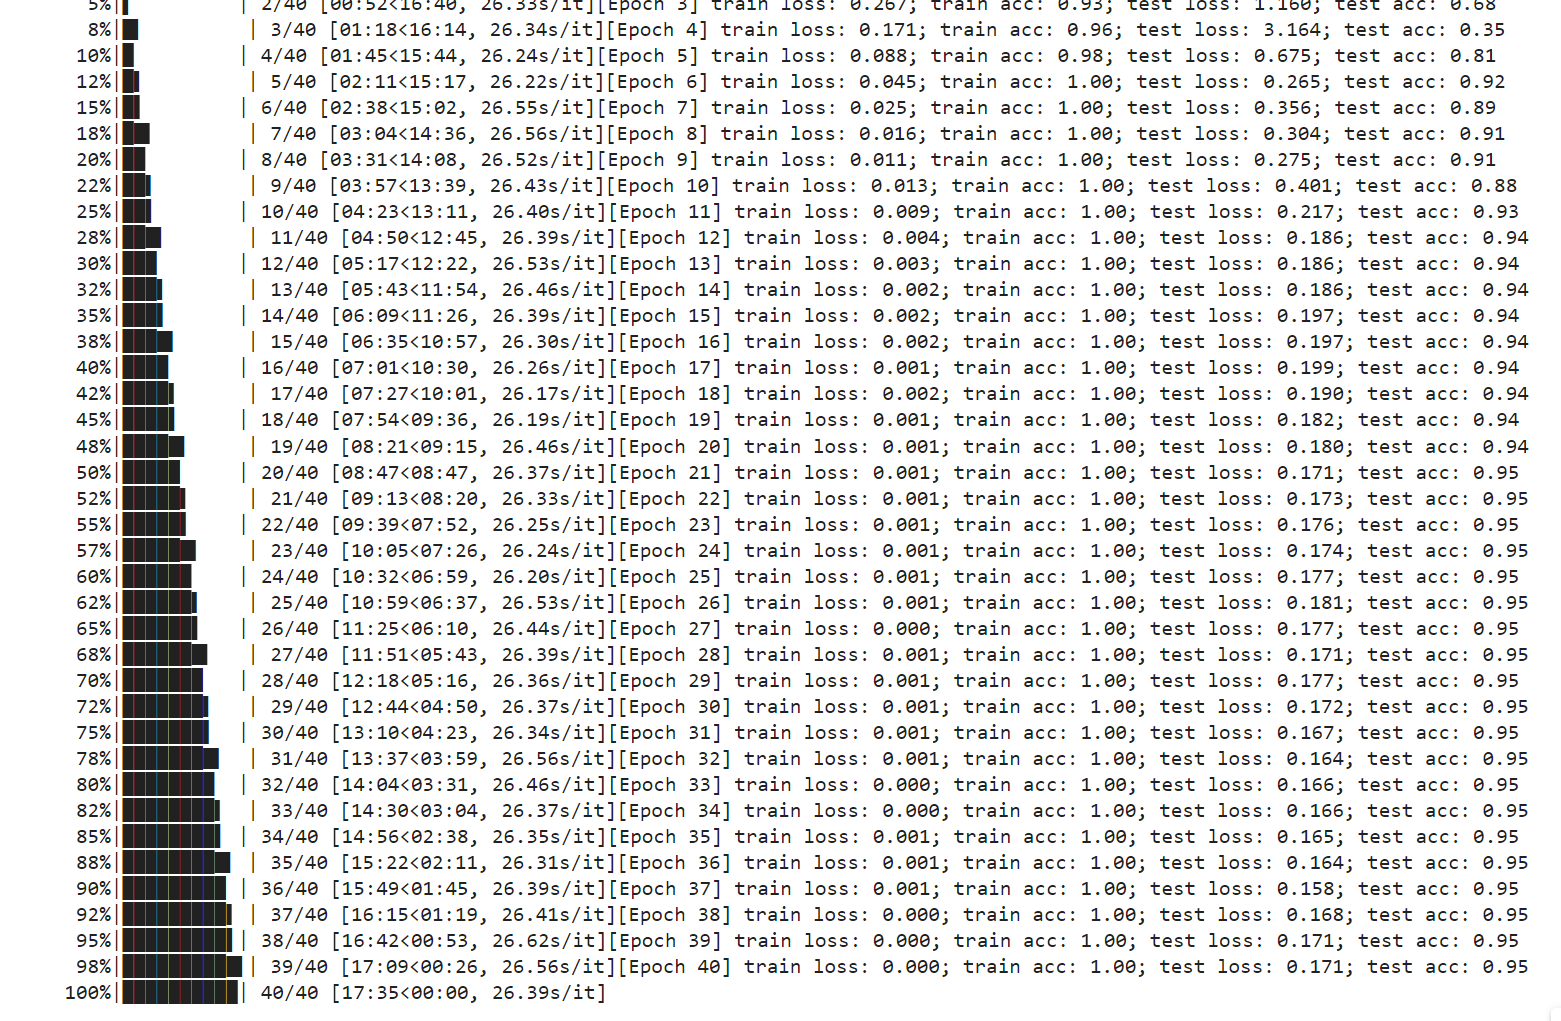